# Escalation analysis 

placeholder

## Summary analysis



In [1]:
import datetime
import dateutil
import pandas as pd
import re
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import os

current_dir = "."

system_files = []
for root, dirs, files in os.walk(current_dir,  topdown=False):
    for name in files:
        if "system.log" in name:
            system_files.append(os.path.join(root, name))

debug_files = []
for root, dirs, files in os.walk(current_dir,  topdown=False):
    for name in files:
        if "debug.log" in name:
            debug_files.append(os.path.join(root, name))

ttop_files = []
for root, dirs, files in os.walk(current_dir,  topdown=False):
    for name in files:
        if "ttop" in name:
            ttop_files.append(os.path.join(root, name))
            
def bucket(dt=None):
    """buckets to the minute"""
    return datetime.datetime(dt.year, dt.month, dt.day, dt.hour, dt.minute)
  
def by_date_bucket(match, date):
    return bucket(date)

def graph_by_regex(regex, title, count_func= lambda a: 1, subplot=False, sum_total=True, start_date = None, end_date=None, files=system_files, chart_type="line", index="time", key_func=by_date_bucket):
    drops_by_node = {}
    for f in files:
        drops = {}
        with open(f) as fd:
            for line in fd:
                drop_match = regex.search(line)
                if drop_match:
                    raw_date = drop_match.group('date')
                    date = datetime.datetime.strptime(raw_date, "%Y-%m-%d %H:%M:%S,%f")
                    if start_date is not None and date < start_date:
                        continue
                    if end_date is not None and date > end_date:
                        continue
                    key = key_func(drop_match, date)
                    count = count_func(drop_match)
                    if sum_total:
                        if key in drops:
                            drops[key] += count
                        else:
                            drops[key] = count
                    else: #use last
                        drops[key] = count
            if len(drops.keys()) > 0:
                drops_by_node[f] = drops
    headers= None
    labels = None
    for f, drops in drops_by_node.items():
        if len(drops) == 0:
            continue
        file_name = f
        drops_pd = pd.DataFrame(list(drops.items()), columns=['time','drops'])
        ax = drops_pd.set_index(index).drops.plot(kind=chart_type,label=file_name, grid=True,  subplots=subplot)
        headers,labels = ax.get_legend_handles_labels()
    plt.title(title)
    plt.xticks(rotation=60)
    if headers is not None:
        plt.legend(headers, labels,  bbox_to_anchor=(1, 1, 1, 0), loc="lower right", mode="expand", ncol=1)
    plt.show()

def graph_by_regex_and_key(regex, title, key_func=lambda m, d, f: f, count_func= lambda a: 1, start_date = None, end_date=None):
    drops_by_node = {}
    for f in files:
        for line in open(f):
            drop_match = regex.search(line)
            if drop_match:
                raw_date = drop_match.group('date')
                date = datetime.datetime.strptime(raw_date, "%Y-%m-%d %H:%M:%S,%f")
                if start_date is not None and date < start_date:
                    continue
                if end_date is not None and date > end_date:
                    continue
                key = key_func(drop_match, date, f)
                count = count_func(drop_match)
                if key in drops_by_node:
                    drops_by_node[key] += count
                else:
                    drops_by_node[key] = count

    headers= None
    labels = None
    for file_name, drops in drops_by_node.items():
        if len(drops) == 0:
            continue
        drops_pd = pd.DataFrame(list(drops.items()), columns=['time','drops'])
        ax = drops_pd.set_index(index).drops.plot(kind=chart_type,label=file_name, grid=True,  subplots=subplot)
        headers,labels = ax.get_legend_handles_labels()
    plt.title(title)
    plt.xticks(rotation=60)
    if headers is not None:
        plt.legend(headers, labels,  bbox_to_anchor=(1, 1, 1, 0), loc="lower right", mode="expand", ncol=1)
    plt.show()
    
def bar_by_regex(regex, title, horiz=False, count_func= lambda a: 1, sum_total=True, start_date = None, end_date=None, files=system_files, key_func=lambda m, f: f.split("/")[-4], filter_values=lambda k,v: True):
    matches = {}
    for f in files:
        for line in open(f):
            drop_match = regex.search(line)
            if drop_match:
                raw_date = drop_match.group('date')
                date = datetime.datetime.strptime(raw_date, "%Y-%m-%d %H:%M:%S,%f")
                if start_date is not None and date < start_date:
                    continue
                if end_date is not None and date > end_date:
                    continue
                key = key_func(drop_match, f)
                count = count_func(drop_match)
                if sum_total:
                    if key in matches:
                        matches[key] += count
                    else:
                        matches[key] = count
                else: #use last
                    matches[key] = count
    if len(matches) > 0:
        matches = {k:v for (k, v) in matches.items() if filter_values(k, v)}
        drops_pd = pd.DataFrame(list(matches.items()), index=matches.keys(), columns=['key','val'])
        t = 'bar'
        if horiz:
            t = 'barh'
        drops_pd.plot(kind=t)

def pie_by_regex_and_date_regex(date_regex, data_regex, title, key_func, count_func: lambda m: 1, filter_values=lambda k,v: True, files=[]):
    matches = {}
    for file_path in files:
        current_date = None
        with open(file_path) as f:
            for line in f:
                date_match = date_regex.search(line)
                data_match = data_regex.search(line)
                # match regex on date
                if date_match:
                    current_date = dateutil.parser.isoparse(date_match.group("date"))
                elif data_match: #failing that match on data
                    key = key_func(data_match, current_date, file_path)
                    count = count_func(data_match)
                    if key in matches:
                        matches[key] += count
                    else:
                        matches[key] = count
    if len(matches) > 0:
        matches = {k:v for (k, v) in matches.items() if filter_values(k, v)}
        drops_pd = pd.DataFrame(list(matches.items()), index=matches.keys(), columns=['key','val'])
        ax = drops_pd.plot(kind='pie', y="val")
        headers,labels = ax.get_legend_handles_labels()
        plt.title(title)
        if headers is not None:
            plt.legend(headers, labels,  bbox_to_anchor=(1, 1, 1, 0), loc="lower right")
        plt.show()

    
def graph_by_regex_and_date_regex(date_regex, data_regex, title, key_func, count_func: lambda m: 1, filter_values=lambda k,v: True, files=[]):
    matches_by_file = {}
    for file_path in files:
        current_date = None
        matches = {}
        with open(file_path) as f:
            for line in f:
                date_match = date_regex.search(line)
                data_match = data_regex.search(line)
                # match regex on date
                if date_match:
                    current_date = dateutil.parser.isoparse(date_match.group("date"))
                elif data_match: #failing that match on data
                    key = key_func(data_match, current_date, file_path)
                    count = count_func(data_match)
                    if key in matches:
                        matches[key] += count
                    else:
                        matches[key] = count
            if len(matches) > 0:
                matches_by_file[file_path] = matches
    headers= None
    labels = None
    for file_name, matches in matches_by_file.items():
        matches = {k:v for (k, v) in matches.items() if filter_values(k, v)}
        matches_pd = pd.DataFrame(list(matches.items()), columns=['time','val'])
        ax = matches_pd.set_index("time").val.plot(kind='line',label=file_name, grid=True)
        headers,labels = ax.get_legend_handles_labels()
    plt.title(title)
    plt.xticks(rotation=60)
    if headers is not None:
        plt.legend(headers, labels,  bbox_to_anchor=(1, 1, 1, 0), loc="lower right", mode="expand", ncol=1)
    plt.show()

## Drops

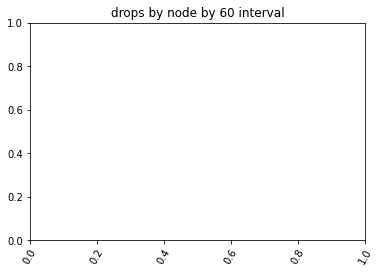

In [2]:
normal_drops_re = re.compile(r"INFO  \[(?P<thread>.*)\] (?P<date>.{10} .{12}) *(?P<source_file>[^:]*):(?P<source_line>[0-9]*) - (?P<messageType>\S*) messages were dropped in the last 5 s: (?P<localCount>\d*) internal and (?P<remoteCount>\d*) cross node. Mean internal dropped latency: (?P<localLatency>\d*) ms and Mean cross-node dropped latency: (?P<remoteLatency>\d*) ms")
def count_dropped(match):
    local = match.group('localCount')
    remote = match.group('remoteCount')
    return int(local) + int(remote)

graph_by_regex(normal_drops_re, "drops by node by 60 interval", count_dropped )

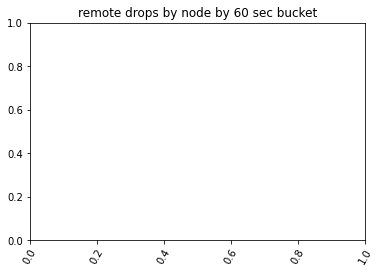

In [3]:
def count_remote_dropped(match):
    remote = match.group('remoteCount')
    return int(remote)
graph_by_regex(normal_drops_re, "remote drops by node by 60 sec bucket", count_remote_dropped )

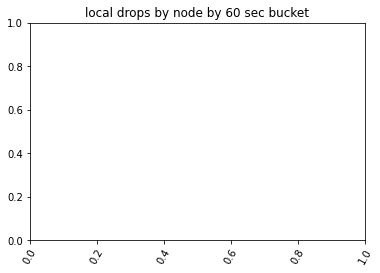

In [4]:
def count_local(match):
    local = match.group('localCount')
    return int(local)
graph_by_regex(normal_drops_re, "local drops by node by 60 sec bucket", count_local )

## Zero Copy Problems

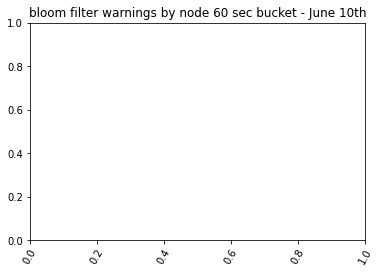

In [5]:
bloom_filter_reg = re.compile(r"WARN  \[(?P<thread>.*)\] (?P<date>.{10} .{12}) *(?P<source_file>[^:]*):(?P<source_line>[0-9]*) - Could not recreate or deserialize existing bloom filter, continuing with a pass-through bloom filter but this will significantly impact reads performance")
graph_by_regex(bloom_filter_reg, "bloom filter warnings by node 60 sec bucket - June 10th")

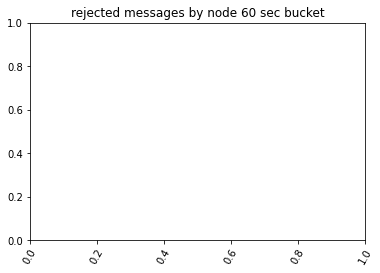

In [6]:
rejected = re.compile(r"WARN  \[(?P<thread>.*)\] (?P<date>.{10} .{12}) *(?P<source_file>[^:]*):(?P<source_line>[0-9]*) - Rejecting droppable message on connection (?P<message_type>.+) with id (?P<id>\d+) from \/(?P<source_ip>.+) to \/(?P<dest_ip>.+) via \((?P<via_ips>.+)\), total dropped: (?P<total_dropped>.\d+), total pending: (?P<total_pending>.\d+), total completed: (?P<total_completed>.\d+)\.")
graph_by_regex(rejected, "rejected messages by node 60 sec bucket")

## Network message backpressure

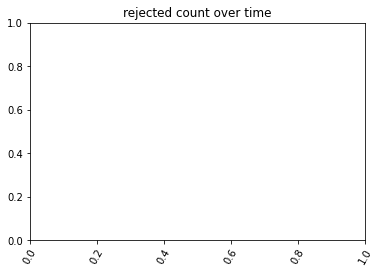

In [7]:
graph_by_regex(rejected, "rejected count over time", key_func= lambda m, d:  d,count_func=lambda m: int(m.group("total_pending")))

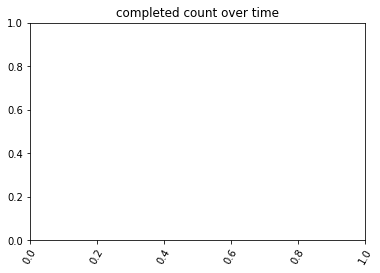

In [8]:
graph_by_regex(rejected, "completed count over time", key_func= lambda m, d:  d,count_func=lambda m: int(m.group("total_completed")))

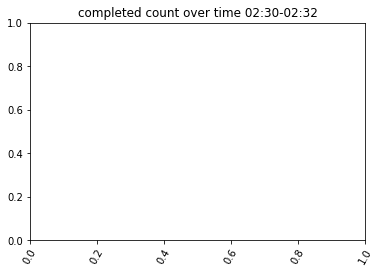

In [9]:

graph_by_regex(rejected, "completed count over time 02:30-02:32", key_func= lambda m, d:  d,count_func=lambda m: int(m.group("total_completed")),
              start_date=datetime.datetime(2021, 6, 23, 2, 30),
              end_date=datetime.datetime(2021, 6, 23, 2, 33))

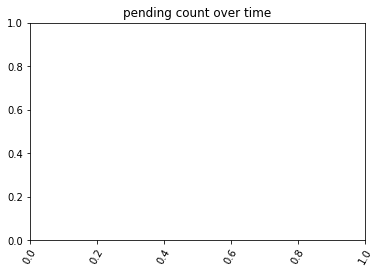

In [10]:
graph_by_regex(rejected, "pending count over time", key_func= lambda m, d:  d,count_func=lambda m: int(m.group("total_pending")))

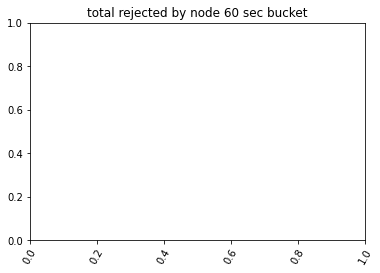

In [11]:
graph_by_regex(rejected, "total rejected by node 60 sec bucket", count_func=lambda m: int(m.group("total_dropped")))

In [12]:
bar_by_regex(rejected, "rejected messages by destination node",  key_func=lambda m, f: m.group("dest_ip"))

## Backpressure traditional

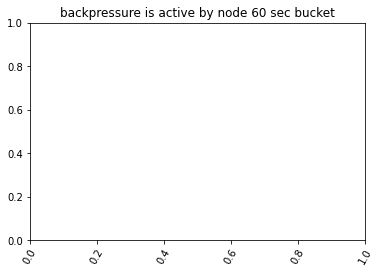

In [13]:
back_pressure_active_re = re.compile(r"DEBUG\s+\[(?P<thread>.*)\] (?P<date>.{10} .{12}) *(?P<source_file>[^:]*):(?P<source_line>[0-9]*) - TPC backpressure is active on core (?P<core_num>\d+) with global local/remote pending tasks at (?P<global_pending>\d+)/(?P<remote_pending>\d+)")

graph_by_regex(back_pressure_active_re, "backpressure is active by node 60 sec bucket", files=debug_files)

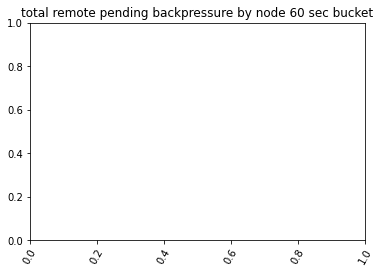

In [14]:
def count_remote_backpressure(match):
    count = match.group('remote_pending')
    return int(count)

graph_by_regex(back_pressure_active_re, "total remote pending backpressure by node 60 sec bucket", count_func=count_remote_backpressure, files=debug_files)

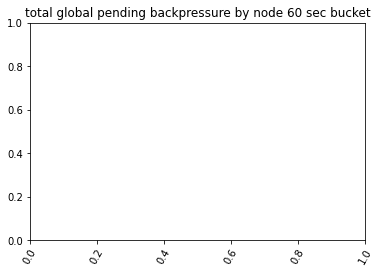

In [15]:
def count_global_backpressure(match):
    count = match.group('global_pending')
    return int(count)

graph_by_regex(back_pressure_active_re, "total global pending backpressure by node 60 sec bucket", count_func= count_global_backpressure, files=debug_files)

In [16]:
disable_auto_read_re = re.compile(r"DEBUG \[(?P<thread>.*)\] (?P<date>.{10} .{12}) *(?P<source_file>[^:]*):(?P<source_line>[0-9]*) - Disabling auto-read from \/(?P<source_ip>[0-9]+\.[0-9]+\.[0-9]+\.[0-9]+)\:(?P<source_port>\d+) due to change in backpressure\.")

bar_by_regex(disable_auto_read_re, "disabling auto read by node destination", files=debug_files,  key_func=lambda m, d: m.group("source_ip") )

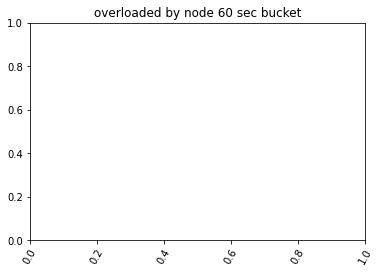

In [17]:
overloaded_re = re.compile("WARN  \[(?P<thread>.*)\] (?P<date>.{10} .{12}) *(?P<source_file>[^:]*):(?P<source_line>[0-9]*) - OverloadedException while processing request from \/(?P<source>.+)")
graph_by_regex(overloaded_re, "overloaded by node 60 sec bucket")


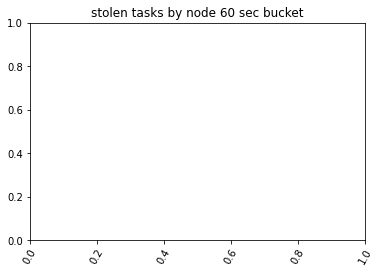

In [18]:
stolen_tasks = re.compile("DEBUG \[(?P<thread>.*)\] (?P<date>.{10} .{12}) *(?P<source_file>[^:]*):(?P<source_line>[0-9]*) - Stole (?P<tasks>\d+) tasks since last time\.")
graph_by_regex(stolen_tasks, "stolen tasks by node 60 sec bucket", files=debug_files, count_func=lambda m: int(m.group("tasks")))


## Tombstones

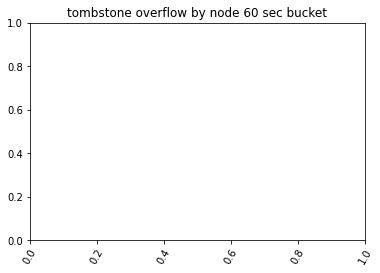

In [19]:
ts_error_regex = re.compile(r"ERROR \[(?P<thread>.*)\] (?P<date>.{10} .{12}) *(?P<source_file>[^:]*):(?P<source_line>[0-9]*) - Scanned over (?P<tombstones>[0-9]*) tombstones during query '(?P<query>.*)' \(last scanned row partion key was \((?P<pk>.*)\)\); query aborted")
graph_by_regex(ts_error_regex, "tombstone overflow by node 60 sec bucket")


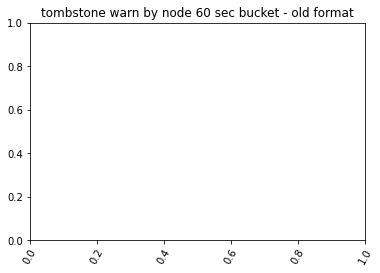

In [20]:
ts_warn_regex = re.compile(r"WARN\s*\[(?P<thread>.*)\] (?P<date>.{10} .{12}) *(?P<source_file>[^:]*):(?P<source_line>[0-9]*) - Read (?P<live>[0-9]*) live rows and (?P<tombstones>[0-9]*) tombstone cells for query (?P<query>.*) \(see tombstone_warn_threshold\)")

graph_by_regex(ts_warn_regex, "tombstone warn by node 60 sec bucket - old format")

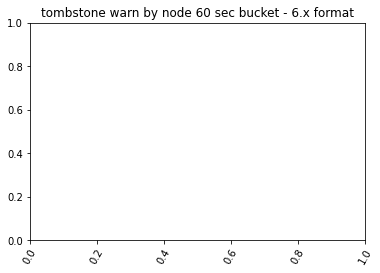

In [21]:
ts_6x_warn_regex = re.compile(r"WARN\s*\[(?P<thread>.*)\] (?P<date>.{10} .{12}) *(?P<source_file>[^:]*):(?P<source_line>[0-9]*) - Scanned over (?P<tombstones>[0-9]*) tombstone rows for query (?P<query>.*) - more than the warning threshold [\d+]")

graph_by_regex(ts_6x_warn_regex, "tombstone warn by node 60 sec bucket - 6.x format")

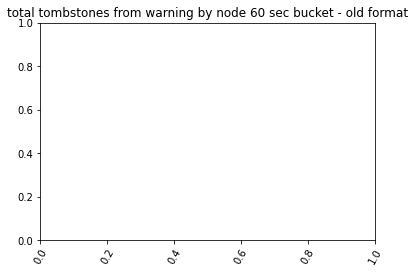

In [22]:
graph_by_regex(ts_warn_regex, "total tombstones from warning by node 60 sec bucket - old format", count_func=lambda m: int(m.group("tombstones")))

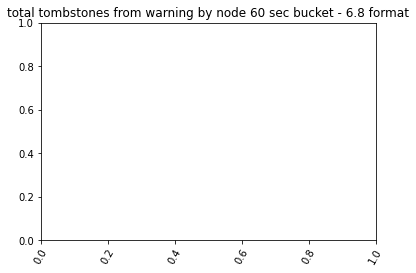

In [23]:
graph_by_regex(ts_6x_warn_regex, "total tombstones from warning by node 60 sec bucket - 6.8 format", count_func=lambda m: int(m.group("tombstones")))

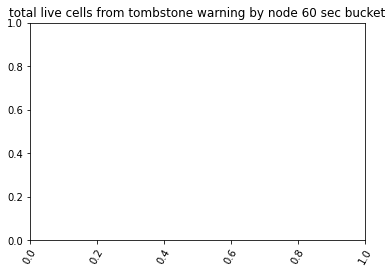

In [24]:
graph_by_regex(ts_warn_regex, "total live cells from tombstone warning by node 60 sec bucket", count_func= lambda m: int(m.group("live")))

In [25]:
bar_by_regex(ts_warn_regex, "tombstones by query - old format",  key_func=lambda m, f: m.group("query"), count_func=lambda m: int(m.group("tombstones")))

In [26]:
def filter_by_size(k, v):
    if v > 100000:
        print("query: '%s' - tombstones: %i" %  (k, v))
        return True
    return False

bar_by_regex(ts_6x_warn_regex, "tombstones by query more than 100000 times - 6.8 format", horiz=True, key_func=lambda m, f: m.group("query"), count_func=lambda m: int(m.group("tombstones")), filter_values=filter_by_size )

## Hot Threads

In [27]:
ttop_cpu_regex = re.compile(r"^\[.*\] user=\s*?(?P<user>\-?[0-9]*.[0-9][0-9])% sys=\s*?(?P<sys>\-?[0-9]*.[0-9][0-9])%.* - (?P<thread>.*)")

def total_cpu(m):
    user_cpu = m.group("user")
    sys_cpu = m.group("sys")
    total_cpu = float(user_cpu) + float(sys_cpu)
    if total_cpu > 89.99:
        return 1
    return 0

def aggregate_thread(m, f):
    # some bad black magic on thread name to make the reporting better
    thread = m.group("thread")
    #thread = thread.split("-")[0]
    # inbound adds the ip so we are going to remove that since we are analyzing several at once
    if thread == "Inbound":
        tokens = m.group("thread").split("-")
        sans_ip = [tokens[0]] + tokens[2:5]
        thread = "-".join(sans_ip)
    if ":" in thread: # if the thread contains the source name we can safely remove that
        thread = thread.split(":")[0]
    elif thread.startswith("CoreThread"): 
        thread = "CoreThread"
    elif thread.startswith("Lucene Merge Thread"): 
        # lucene merge thread adds the thread number
        # so let us remove it
        thread = "Lucene Merge Thread"
    elif thread.startswith("RMI TCP"):
        thread = "RMI TCP Connection"
    elif thread.startswith("JMX server connection timeout"):
        thread = "JMX server connection timeout"
    elif thread.startswith("dsefs-netty-worker"):
        thread = "dsefs-netty-worker"
    elif thread.startswith("pool"):
        thread = "pool-x-thread-y"
    elif thread.startswith("PO-thread"):
        thread = "PO-thread"
    elif thread.startswith("mainIOThread"):
        thread = "mainIOThread"
    elif thread.startswith("LeasePlugin"):
        thread = "LeasePlugin"
    return thread
    
bar_by_regex(ts_warn_regex, "hot cores by reason", files=ttop_files,count_func=total_cpu, key_func=aggregate_thread)

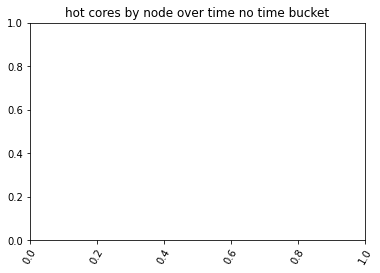

In [28]:
ttop_date_regex = re.compile(r"^(?P<date>.{10}T.{17}) Process summary")
graph_by_regex_and_date_regex(date_regex=ttop_date_regex, title="hot cores by node over time no time bucket",  data_regex=ttop_cpu_regex, files=ttop_files, count_func=total_cpu, key_func= lambda m, d, f: d)

In [29]:

pie_by_regex_and_date_regex(date_regex=ttop_date_regex, title="cpu share of threads",  data_regex=ttop_cpu_regex, files=ttop_files, count_func=lambda m: float(m.group("user")) + float(m.group("sys")), key_func= lambda m, d, f: aggregate_thread(m, f), filter_values= lambda k, v: v > 1.00)

In [30]:
### by core

pie_by_regex_and_date_regex(date_regex=ttop_date_regex, title="cpu share of core threads",  data_regex=ttop_cpu_regex, files=ttop_files, count_func=lambda m: float(m.group("user")) + float(m.group("sys")), key_func= lambda m, d, f: m.group("thread"), filter_values= lambda k, v: k.startswith("CoreThread"))

## hints

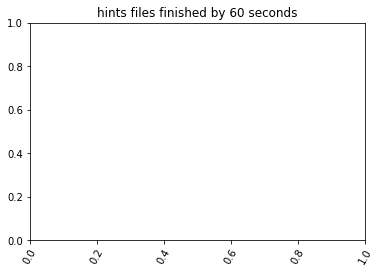

In [31]:
hints_finished_re = re.compile(r"INFO  \[(?P<thread>.*)\] (?P<date>.{10} .{12}) *(?P<source_file>[^:]*):(?P<source_line>[0-9]*) - Finished hinted handoff of file (?P<hint_file>.+) to endpoint (?P<endpoint>.+): (?P<endpoint_uuid>.+), completed")

graph_by_regex(hints_finished_re, "hints files finished by 60 seconds")

In [32]:
bar_by_regex(hints_finished_re, "hints files destination",  key_func=lambda m, f: m.group("endpoint"))